# Preamble
**Name:** Deborah Djon</br>
**Student Number:** 22261972</br>
**Module Code:** CA694</br>
**Module Name:** Practicum</br>
**Supervisor:** Dr. Geoff Hamilton</br>

## **Plagiarism Policy**
I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. I have read and understood the Assignment Regulations. I have identified and included the source of all facts, ideas, opinions, and viewpoints of others in the assignment references. Direct quotations from books, journal articles, internet sources, module text, or any other source whatsoever are acknowledged and the source cited are identified in the assignment references. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</br>

I have read and understood the referencing guidelines found at
http://www.dcu.ie/info/regulations/plagiarism.shtml,
https://www4.dcu.ie/students/az/plagiarism and/or recommended in the assignment
guidelines.

# Measuring Class Uniqueness Using DTW and Cross Correlation

## Imports

In [3]:
import sys
sys.path.append("../..")
from modelling_utilities.constants import *
from modelling_utilities import data_processing, visualisation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import pandas as pd
import shutil
import os
from datetime import timedelta, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

In [6]:
def create_data_set(dataset, feature_name, rdm_state) -> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    dataset = dataset[["class", feature_name]][dataset.cw==1].copy()
    dataset["var"] = dataset[feature_name].apply(np.var)

    # Create training and testing datasets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=rdm_state)
    iterator = sss.split(y = dataset["class"], X=dataset[feature_name])
    for i, (train_index, test_index) in enumerate(iterator):
        train_index = train_index
        test_index = test_index
    X_train = dataset[[feature_name, "var"]].iloc[train_index]
    y_train = dataset["class"][train_index]
    X_test = dataset[feature_name][test_index]
    y_test = dataset["class"][test_index]
    # Get fingerprints / training
    fingerprints = {}
    rm_from_train = [ ]
    classes = dataset["class"][:-1]

    # Select features
    for c in classes: 
            class_data = X_train[y_train==c]
            class_data = class_data.sort_values("var")
            fingerprints[c] = class_data[:15][feature_name]
            rm_from_train.extend(fingerprints[c].index)
            fingerprints[c].reset_index(inplace=True, drop=True)
    
    X_train = X_train[feature_name].drop(rm_from_train)
    y_train = y_train.drop(rm_from_train)
    fingerprints = {class_name: visualisation.average_sequences(f_prints) for class_name, f_prints in fingerprints.items()}
    return X_train, X_test, y_train, y_test, fingerprints

def purge_folder(dir_name):
    shutil.rmtree(dir_name)
    print("Deleted: ", dir_name)
    os.makedirs(dir_name)
    print("Created: ", dir_name)

def get_evaluations_dict(fp_types):
    pass
    return {
        "fingerprint_method": { # s interval
            fp:{
                "accuracy":[],
                "f1_score":[]
            } for fp in fp_types
        },  
        "bpi_scale": {
            fp:{
                    "log":{
                        "accuracy":[],
                        "f1_score":[]
                    },
                    "regular":{
                        "accuracy":[],
                        "f1_score":[]
                    }
            } for fp in fp_types
        },
        "binsize": {            # alle durch mit einem fp
            fp:{
                ms:{
                    "accuracy":[],
                    "f1_score":[]
                } for ms in range(10, 1001, 10)
            } for fp in fp_types
        },             
        "fingerprint_characteristics": { # length, variance, random. accuracy of the model when averaging top x traces of characteristic
            fp:{
                char:{
                    i:{
                        "accuracy":0,
                        "f1_score":0
                    } for i in range(1, 11)
                    
                } for char in ["variance", "length", "random"] 
            } for fp in fp_types
        } 
    }          

In [96]:
evaluation_folder = CLOSED_WORLD_PROCESSED_DATA_FOLDER+"DTW/Evaluation/"
evaluations_filename = DATA_FOLDER+"Model_Evaluations/evaluation-dtw-all.json"

In [4]:
purge_folder(evaluation_folder)

Deleted:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/
Created:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/


In [35]:
fp_types_all = ['df','df_sparse', 'mpdf', 'mpdf_sparse', 'sdf', 'sdf_sparse', 'ndf', 'ndf_sparse', 'adf', 'adf_sparse']
evaluations = get_evaluations_dict(fp_types_all)

## 1. What is the Best Fingerprinting Method?

We measure the fingerprint by the accuracy that can be archived through using the measure in a dtw model, to predict a series.
We assume the ideal fingerprint is an average created from the 5 traces with the highest variance in the training set. 

In [80]:
binned_data_files = os.listdir(BINNED_DATA_FOLDER)
bin_data_fn = [fn for fn in binned_data_files if str.__contains__(fn, "1000-ms")][0]
bin_data_fp = BINNED_DATA_FOLDER+bin_data_fn
dataset = data_processing.read_parquet_to_pandas(bin_data_fp)
dataset = dataset[dataset["cw"]==1]#[["class", feature]]
classes = list(dataset["class"].unique())

In [81]:
evaluations = get_evaluations_dict(fp_types_all)

In [92]:
fp_types = ['df','df_sparse', 'mpdf', 'mpdf_sparse', 'sdf', 'sdf_sparse', 'ndf', 'ndf_sparse', 'adf', 'adf_sparse']

purge_folder(evaluation_folder)
dts = 10000000 

for i in range(3,6):
    for fp in fp_types:
        print(fp+"-"+str(i))
        X_train, X_test, y_train, y_test, fps = create_data_set(dataset, fp, rdm_state = i)
        model = DTW_Model(distance_threshold=dts, fingerprints=fps)
        predictions, distances = model.predict(list(X_test))
        acc = accuracy_score(y_pred=predictions, y_true=y_test)
        f1 = f1_score(y_pred=predictions, y_true=y_test, average="macro")
        evaluations["fingerprint_method"][fp]["accuracy"].append(acc)
        evaluations["fingerprint_method"][fp]["f1_score"].append(f1)
        fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
        data_processing.write_json(fn, evaluations) 

Progress:[||||||||||||||||||||||||||||||||||||||||||||||||||] 999/1000
Successfully saved file to:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/1689619097.617173-evaluation-dtw.json


In [2]:
DATA_FOLDER

'/home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/'

<AxesSubplot:>

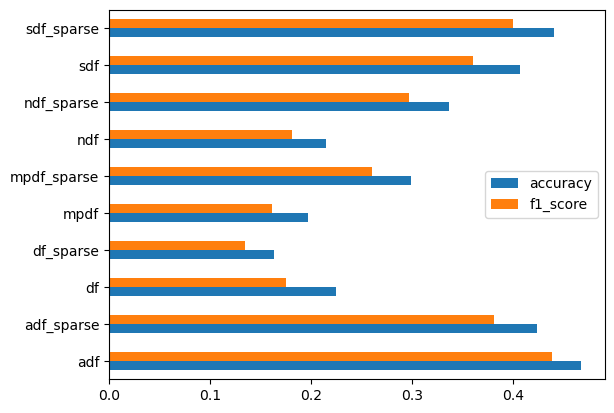

In [14]:
with open(evaluations_filename, "r") as f:
    ev_dict = json.load(f)
fp_method_evaluations = ev_dict["fingerprint_method"]

aggregates_evals = {
    fp_id:{
            eval_id: np.mean(eval_measure) for eval_id , eval_measure in evals.items()
    }  for fp_id , evals in fp_method_evaluations.items()
}
evals_df = pd.DataFrame(aggregates_evals).T
evals_df.plot(kind="barh")

In [ ]:
# for fn in train_evaluations_fns:
#     bin = int(fn[5:9])
#     fp = evaluation_folder+fn
#     with open(fp, "r") as f:
#         ev_dict = json.load(f)
#         ev_dict = {k:v["mean"] for k,v in ev_dict.items()}
#     train_evaluations[bin] = ev_dict

# train_evaluations_all = pd.DataFrame(train_evaluations).T
# train_evaluations_all = train_evaluations_all.sort_index()
# display(train_evaluations_all)

# test_evaluations = {}
# for fn in test_evaluations_fns:
#     bin = int(fn[5:9])
#     fp = evaluation_folder+fn
#     with open(fp, "r") as f:
#         ev_dict = json.load(f)
#     test_evaluations[int(bin)] = ev_dict['weighted avg']

# test_evaluations = pd.DataFrame(test_evaluations).T
# test_evaluations = test_evaluations.sort_index()
# test_evaluations = test_evaluations.drop("support", axis=1)
# display(test_evaluations)


# train_evaluations = train_evaluations_all[["accuracy", "f1_macro", "precision_macro", "recall_macro"]]
# train_evaluations.columns = ["accuracy", "f1-score", "precision", "recall"]
# train_evaluations = train_evaluations
# #TODO get model accuracies

# train_evaluations.plot()

## 2. Is a Log-Scaled Fingerprint Preferable?
I am now testing the influence of scaling the model to a log scale. This mitegates the effects of large differences between very large and very small byte size measures. 

In [41]:
regular_data_fp = CLOSED_WORLD_PROCESSED_DATA_FOLDER+"Pre_Processed_Bin_Aggregates/data-ms-aggregates/data-1000-ms-aggregate.parquet"
log_scaled_data_fp = CLOSED_WORLD_PROCESSED_DATA_FOLDER+"Pre_Processed_Bin_Aggregates/data-ms-aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet"
regular_data = data_processing.read_parquet_to_pandas(regular_data_fp)
log_scaled_data = data_processing.read_parquet_to_pandas(log_scaled_data_fp)

In [42]:
fps_types = ["adf", "adf_sparse", "mpdf", "mpdf_sparse"] 
evaluations = get_evaluations_dict(fps_types)
scales = {"regular":regular_data, 
          "log":log_scaled_data}

for i in range(5):
    for scale in scales.keys():
        for fp in fps_types:
            print(fp+"-"+scale+"-"+str(i))
            X_train, X_test, y_train, y_test, fps = create_data_set(scales[scale], fp, rdm_state = i)
            model = DTW_Model(distance_threshold=dts, fingerprints=fps)
            predictions, distances = model.predict(list(X_test))
            acc = accuracy_score(y_pred=predictions, y_true=y_test)
            f1 = f1_score(y_pred=predictions, y_true=y_test, average="macro")
            evaluations["bpi_scale"][fp][scale]["accuracy"].append(acc)
            evaluations["bpi_scale"][fp][scale]["f1_score"].append(f1)
            fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
            data_processing.write_json(fn, evaluations) 

In [5]:
with open(evaluations_filename, "r") as f:
    ev_dict = json.load(f)
scale_evaluations_all = ev_dict["bpi_scale"]

In [7]:
scale_evaluations_all

{'adf': {'log': {'accuracy': [0.252, 0.31, 0.282, 0.311, 0.288],
   'f1_score': [0.21540355951463602,
    0.23747784564272012,
    0.2334508123986171,
    0.2572315242918119,
    0.23604786685022458]},
  'regular': {'accuracy': [0.468, 0.49, 0.457, 0.479, 0.424],
   'f1_score': [0.4344900073371923,
    0.455665501680995,
    0.43054479227656933,
    0.4571158340418395,
    0.3912127100580625]}},
 'adf_sparse': {'log': {'accuracy': [0.35, 0.392, 0.33, 0.345, 0.345],
   'f1_score': [0.334910845355088,
    0.36266252063212995,
    0.3024051596233886,
    0.33313735921317433,
    0.3172763712658258]},
  'regular': {'accuracy': [0.406, 0.427, 0.425, 0.452, 0.401],
   'f1_score': [0.3658434488674792,
    0.3788200725454211,
    0.39116856963042523,
    0.4022122600047415,
    0.3647943462215064]}},
 'df': {'log': {'accuracy': [], 'f1_score': []},
  'regular': {'accuracy': [], 'f1_score': []}},
 'df_sparse': {'log': {'accuracy': [], 'f1_score': []},
  'regular': {'accuracy': [], 'f1_score': [

<AxesSubplot:>

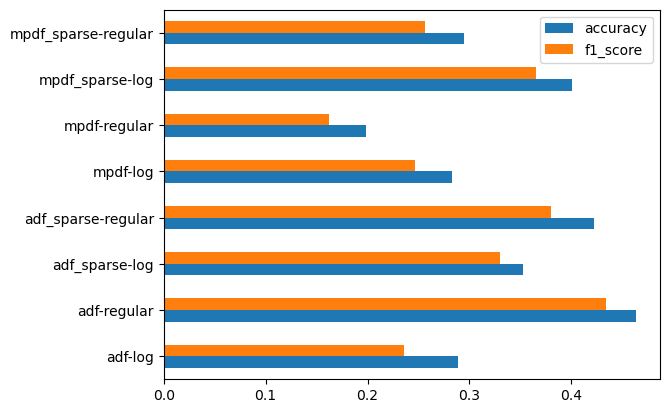

In [13]:
fp_types = ["adf", "adf_sparse", "mpdf", "mpdf_sparse"] 
scales = ["log", "regular"]
aggregates_evals = {
    str(fp_id)+"-"+scale:{
        eval_id: np.mean(eval_measure) for eval_id , eval_measure in evals[scale].items()
    }  for fp_id , evals in scale_evaluations_all.items() if fp_id in fp_types for scale in scales
}
evals_df = pd.DataFrame(aggregates_evals).T
evals_df.plot(kind="barh")

## 3. What is the optimal Binsize?

In [5]:
def num_to_preceding_zero_string(num):
    num_string = str(num)
    zero_string = "0"*(4-len(num_string)) 
    return zero_string + num_string 

In [27]:
evaluations = get_evaluations_dict(["mpdf_sparse", "adf"])
purge_folder(evaluation_folder)

Deleted:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/
Created:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/


In [31]:
regular_data_fp = DATA_FOLDER+"Processed_Data/data-ms-aggregates/data-1000-ms-aggregate.parquet"
log_scaled_data_fp = DATA_FOLDER+"Processed_Data/data-ms-aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet"

for ms in range(20,1001,20):
    ms_string = str(ms)
    ms_string = num_to_preceding_zero_string(ms)
    filename = log_scaled_data_fp.replace("1000", ms_string)
    df = data_processing.read_parquet_to_pandas(filename)
    fp = "mpdf_sparse"
    print(ms_string+"-"+fp)
    X_train, X_test, y_train, y_test, fps = create_data_set(df, fp, rdm_state = 42)
    model = DTW_Model(distance_threshold=dts, fingerprints=fps)
    predictions, distances = model.predict(list(X_test))
    acc = accuracy_score(y_pred=predictions, y_true=y_test)
    f1 = f1_score(y_pred=predictions, y_true=y_test, average="macro")
    evaluations["binsize"][fp][ms]["accuracy"].append(acc)
    evaluations["binsize"][fp][ms]["f1_score"].append(f1)
    fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
    data_processing.write_json(fn, evaluations) 

fn = evaluation_folder+str(datetime.now().timestamp())+"-FINISJED_LOGSCALED.json"
data_processing.write_json(fn, evaluations) 


for ms in range(20,1001,20):
    ms_string = str(ms)
    ms_string = num_to_preceding_zero_string(ms)
    filename = regular_data_fp.replace("1000", ms_string)
    df = data_processing.read_parquet_to_pandas(filename)
    fp = "adf"
    print(ms_string+"-"+fp)
    X_train, X_test, y_train, y_test, fps = create_data_set(df, fp, rdm_state = 42)
    model = DTW_Model(distance_threshold=dts, fingerprints=fps)
    predictions, distances = model.predict(list(X_test))
    acc = accuracy_score(y_pred=predictions, y_true=y_test)
    f1 = f1_score(y_pred=predictions, y_true=y_test, average="macro")
    evaluations["binsize"][fp][ms]["accuracy"].append(acc)
    evaluations["binsize"][fp][ms]["f1-score"].append(f1)
    fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
    data_processing.write_json(fn, evaluations) 

Progress:[||||||||||||||||||||||||||||||||||||||||||||||||||] 999/1000
Successfully saved file to:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/1689630654.133924-evaluation-dtw.json


In [140]:
with open(evaluations_filename, "r") as f:
    ev_dict = json.load(f)
binsize_evaluations_all = ev_dict["binsize"]
binsize_evaluations_all

{'adf': {'10': {'accuracy': [0.383], 'f1_score': [0.3388059490142985]},
  '20': {'accuracy': [0.386], 'f1_score': [0.3430246842834127]},
  '30': {'accuracy': [0.398], 'f1_score': [0.3477803295708399]},
  '40': {'accuracy': [0.41], 'f1_score': [0.354214812507135]},
  '50': {'accuracy': [0.404], 'f1_score': [0.34658729043526854]},
  '60': {'accuracy': [0.423], 'f1_score': [0.37150386599349133]},
  '70': {'accuracy': [0.426], 'f1_score': [0.3761506688240299]},
  '80': {'accuracy': [0.412], 'f1_score': [0.37269408306738083]},
  '90': {'accuracy': [0.439], 'f1_score': [0.40011634045746797]},
  '100': {'accuracy': [0.43], 'f1_score': [0.3745121523778817]},
  '110': {'accuracy': [0.456], 'f1_score': [0.41008145056551953]},
  '120': {'accuracy': [0.464], 'f1_score': [0.42308629067713566]},
  '130': {'accuracy': [0.462], 'f1_score': [0.4254743841194427]},
  '140': {'accuracy': [0.44], 'f1_score': [0.40091510016309656]},
  '150': {'accuracy': [0.427], 'f1_score': [0.38253508398949804]},
  '160':

<Axes: >

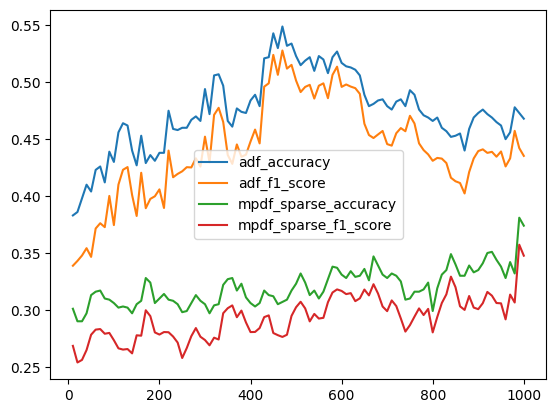

In [146]:
fp_types = ["adf", "mpdf_sparse"] 

aggregates_evals = {
    ms: {
        fp+"_"+eval_name : eval_value[0]
        for fp, eval_items in binsize_evaluations_all.items() for eval_name, eval_value in eval_items[str(ms)].items()
    } for ms in range(10,1001,10) 
} 
evals_df = pd.DataFrame(aggregates_evals).T
evals_df.plot()

In [154]:
evals_df.adf_accuracy.idxmax()

470

## 4. What makes a good fingerprint?

In [33]:
def create_data_set_no_fp(dataset, feature_name, rdm_state) -> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    dataset = dataset[["class", feature_name]][dataset.cw==1].copy()

    # Create training and testing datasets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=rdm_state)
    iterator = sss.split(y = dataset["class"], X=dataset[feature_name])
    for i, (train_index, test_index) in enumerate(iterator):
        train_index = train_index
        test_index = test_index
    X_train = dataset[feature_name].iloc[train_index]
    y_train = dataset["class"][train_index]
    X_test = dataset[feature_name][test_index]
    y_test= dataset["class"][test_index]

    return X_train, X_test, y_train, y_test


In [47]:
evaluations = get_evaluations_dict(fps_types)["fingerprint_characteristics"]

regular_data_fp = CLOSED_WORLD_PROCESSED_DATA_FOLDER+"Pre_Processed_Bin_Aggregates/data-ms-aggregates/data-1000-ms-aggregate.parquet"
log_scaled_data_fp = CLOSED_WORLD_PROCESSED_DATA_FOLDER+"Pre_Processed_Bin_Aggregates/data-ms-aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet"
regular_data = data_processing.read_parquet_to_pandas(regular_data_fp)
log_scaled_data = data_processing.read_parquet_to_pandas(log_scaled_data_fp)
#purge_folder(evaluation_folder)
fps_types_data = {
    "mpdf_sparse": log_scaled_data, 
    "adf": regular_data
}

In [31]:
# Most variance trace
for fp in fps_types_data.keys():
    fingerprints = {}
    rm_from_train = [ ] 
    X_train, X_test, y_train, y_test = create_data_set_no_fp(fps_types_data[fp], fp, rdm_state=42)

    X_train = pd.DataFrame({fp:X_train, "var":X_train.apply(lambda x: np.var(x))})

    # Select features
    for c in classes: 
        class_data = X_train[y_train==c]
        class_data = class_data.sort_values("var")
        fingerprints[c] = class_data[:15][fp]
        rm_from_train.extend(fingerprints[c].index)
        fingerprints[c].reset_index(inplace=True, drop=True)
    
    X_train = X_train[fp].drop(rm_from_train)
    y_train = y_train.drop(rm_from_train)

    # Highest Var trace
    fps = {v_id:fp[0] for v_id, fp in fingerprints.items()}
    model = DTW_Model(distance_threshold=dts, fingerprints=fps)
    predictions, distances = model.predict(list(X_train))
    acc = accuracy_score(y_pred=predictions, y_true=y_train)
    f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
    evaluations[fp]["variance"][1]["accuracy"] = acc
    evaluations[fp]["variance"][1]["f1_score"] = f1
    fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
    data_processing.write_json(fn, evaluations) 


    # Average of 2-10 highest variance traces
    for i in range(2,11):
        fps = {v_id:visualisation.average_sequences(fp[:i]) for v_id, fp in fingerprints.items()}
        model = DTW_Model(distance_threshold=dts, fingerprints=fps)
        predictions, distances = model.predict(list(X_test))
        acc = accuracy_score(y_pred=predictions, y_true=y_test)
        f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
        evaluations[fp]["variance"][i]["accuracy"] = acc
        evaluations[fp]["variance"][i]["f1_score"] = f1
        fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
        data_processing.write_json(fn, evaluations) 
evaluations

NameError: name 'fps_types_data' is not defined

In [ ]:
# Longest traces
for fp in fps_types_data.keys():
    fingerprints = {}
    rm_from_train = [ ] 
    X_train, X_test, y_train, y_test = create_data_set_no_fp(fps_types_data[fp], fp, rdm_state=42)

    X_train = pd.DataFrame({fp:X_train, "len":X_train.apply(lambda x: len(x))})

    # Select features
    for c in classes: 
        class_data = X_train[y_train==c]
        class_data = class_data.sort_values("len")
        fingerprints[c] = class_data[:15][fp]
        rm_from_train.extend(fingerprints[c].index)
        fingerprints[c].reset_index(inplace=True, drop=True)
    
    X_train = X_train[fp].drop(rm_from_train)
    y_train = y_train.drop(rm_from_train)

    # Longest trace
    fps = {v_id:fp[0] for v_id, fp in fingerprints.items()}
    model = DTW_Model(distance_threshold=dts, fingerprints=fps)
    predictions, distances = model.predict(list(X_train))
    acc = accuracy_score(y_pred=predictions, y_true=y_train)
    f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
    evaluations[fp]["length"][1]["accuracy"] = acc
    evaluations[fp]["length"][1]["f1_score"] = f1
    fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
    data_processing.write_json(fn, evaluations) 


    # Average of 2-10 longest traces
    for i in range(2,11):
        fps = {v_id:visualisation.average_sequences(fp[:i]) for v_id, fp in fingerprints.items()}
        model = DTW_Model(distance_threshold=dts, fingerprints=fps)
        predictions, distances = model.predict(list(X_test))
        acc = accuracy_score(y_pred=predictions, y_true=y_test)
        f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
        evaluations[fp]["length"][i]["accuracy"] = acc
        evaluations[fp]["length"][i]["f1_score"] = f1
        fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
        data_processing.write_json(fn, evaluations) 

evaluations

Progress:[||||||||||||||||||||||||||||||||||||||||||||||||||] 999/1000
Successfully saved file to:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/1689703011.163549-evaluation-dtw.json


{'mpdf_sparse': {'variance': {1: {'accuracy': 0.11866666666666667,
    'f1_score': 0.07551582146895894},
   2: {'accuracy': 0.16, 'f1_score': 0.07551582146895894},
   3: {'accuracy': 0.188, 'f1_score': 0.07551582146895894},
   4: {'accuracy': 0.221, 'f1_score': 0.07551582146895894},
   5: {'accuracy': 0.204, 'f1_score': 0.07551582146895894},
   6: {'accuracy': 0.217, 'f1_score': 0.07551582146895894},
   7: {'accuracy': 0.227, 'f1_score': 0.07551582146895894},
   8: {'accuracy': 0.25, 'f1_score': 0.07551582146895894},
   9: {'accuracy': 0.258, 'f1_score': 0.07551582146895894},
   10: {'accuracy': 0.281, 'f1_score': 0.07551582146895894}},
  'length': {1: {'accuracy': 0.31066666666666665,
    'f1_score': 0.2970805653809751},
   2: {'accuracy': 0.221, 'f1_score': 0.2970805653809751},
   3: {'accuracy': 0.239, 'f1_score': 0.2970805653809751},
   4: {'accuracy': 0.227, 'f1_score': 0.2970805653809751},
   5: {'accuracy': 0.24, 'f1_score': 0.2970805653809751},
   6: {'accuracy': 0.256, 'f1_sco

In [7]:
evals_df = pd.DataFrame(evals)


,mpdf_sparse,adf
variance,"{1: {'accuracy': 0.11866666666666667, 'f1_scor...","{1: {'accuracy': 0.22933333333333333, 'f1_scor..."
length,"{1: {'accuracy': 0.31066666666666665, 'f1_scor...","{1: {'accuracy': 0.4093333333333333, 'f1_score..."
random,"{1: {'accuracy': 0, 'f1_score': 0}, 2: {'accur...","{1: {'accuracy': 0, 'f1_score': 0}, 2: {'accur..."


In [ ]:
from random import sample

# Random traces
for fp in fps_types_data.keys():
    fingerprints = {}
    rm_from_train = [ ] 
    X_train, X_test, y_train, y_test = create_data_set_no_fp(fps_types_data[fp], fp, rdm_state=42)

    random_indices = {c:[] for c in classes}

    # Select features
    for c in classes: 
        class_data = X_train[y_train==c]
        class_indices = list(class_data.index)
        class_indices = sample(class_indices, 10)
        fingerprints[c] = class_data[class_indices]
        rm_from_train+=class_indices
        fingerprints[c].reset_index(inplace=True, drop=True)
        
    X_train = X_train.drop(rm_from_train)
    y_train = y_train.drop(rm_from_train)

    # Longest trace
    fps = {v_id:fp[0] for v_id, fp in fingerprints.items()}
    model = DTW_Model(distance_threshold=dts, fingerprints=fps)
    predictions, distances = model.predict(list(X_train))
    acc = accuracy_score(y_pred=predictions, y_true=y_train)
    f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
    evaluations[fp]["random"][1]["accuracy"] = acc
    evaluations[fp]["random"][1]["f1_score"] = f1
    fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
    data_processing.write_json(fn, evaluations) 

    # Average of 2-10 random traces
    for i in range(2,11):
        fps = {v_id:visualisation.average_sequences(fp[:i]) for v_id, fp in fingerprints.items()}
        model = DTW_Model(distance_threshold=dts, fingerprints=fps)
        predictions, distances = model.predict(list(X_test))
        acc = accuracy_score(y_pred=predictions, y_true=y_test)
        f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
        evaluations[fp]["random"][i]["accuracy"] = acc
        evaluations[fp]["random"][i]["f1_score"] = f1
        fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
        data_processing.write_json(fn, evaluations) 

evaluations

Progress:[||||||||||||||||||||||||||||||||||||||||||||||||||] 999/1000
Successfully saved file to:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/DTW/Evaluation/1689704477.713425-evaluation-dtw.json


{'mpdf_sparse': {'variance': {1: {'accuracy': 0.11866666666666667,
    'f1_score': 0.07551582146895894},
   2: {'accuracy': 0.16, 'f1_score': 0.07551582146895894},
   3: {'accuracy': 0.188, 'f1_score': 0.07551582146895894},
   4: {'accuracy': 0.221, 'f1_score': 0.07551582146895894},
   5: {'accuracy': 0.204, 'f1_score': 0.07551582146895894},
   6: {'accuracy': 0.217, 'f1_score': 0.07551582146895894},
   7: {'accuracy': 0.227, 'f1_score': 0.07551582146895894},
   8: {'accuracy': 0.25, 'f1_score': 0.07551582146895894},
   9: {'accuracy': 0.258, 'f1_score': 0.07551582146895894},
   10: {'accuracy': 0.281, 'f1_score': 0.07551582146895894}},
  'length': {1: {'accuracy': 0.31066666666666665,
    'f1_score': 0.2970805653809751},
   2: {'accuracy': 0.221, 'f1_score': 0.2970805653809751},
   3: {'accuracy': 0.239, 'f1_score': 0.2970805653809751},
   4: {'accuracy': 0.227, 'f1_score': 0.2970805653809751},
   5: {'accuracy': 0.24, 'f1_score': 0.2970805653809751},
   6: {'accuracy': 0.256, 'f1_sco

In [24]:
evals = {'mpdf_sparse': {'variance': {1: {'accuracy': 0.11866666666666667,
    'f1_score': 0.07551582146895894},
   2: {'accuracy': 0.16, 'f1_score': 0.07551582146895894},
   3: {'accuracy': 0.188, 'f1_score': 0.07551582146895894},
   4: {'accuracy': 0.221, 'f1_score': 0.07551582146895894},
   5: {'accuracy': 0.204, 'f1_score': 0.07551582146895894},
   6: {'accuracy': 0.217, 'f1_score': 0.07551582146895894},
   7: {'accuracy': 0.227, 'f1_score': 0.07551582146895894},
   8: {'accuracy': 0.25, 'f1_score': 0.07551582146895894},
   9: {'accuracy': 0.258, 'f1_score': 0.07551582146895894},
   10: {'accuracy': 0.281, 'f1_score': 0.07551582146895894}},
  'length': {1: {'accuracy': 0.31066666666666665,
    'f1_score': 0.2970805653809751},
   2: {'accuracy': 0.221, 'f1_score': 0.2970805653809751},
   3: {'accuracy': 0.239, 'f1_score': 0.2970805653809751},
   4: {'accuracy': 0.227, 'f1_score': 0.2970805653809751},
   5: {'accuracy': 0.24, 'f1_score': 0.2970805653809751},
   6: {'accuracy': 0.256, 'f1_score': 0.2970805653809751},
   7: {'accuracy': 0.22, 'f1_score': 0.2970805653809751},
   8: {'accuracy': 0.257, 'f1_score': 0.2970805653809751},
   9: {'accuracy': 0.262, 'f1_score': 0.2970805653809751},
   10: {'accuracy': 0.276, 'f1_score': 0.2970805653809751}},
  'random': {1: {'accuracy': 0, 'f1_score': 0},
   2: {'accuracy': 0, 'f1_score': 0},
   3: {'accuracy': 0, 'f1_score': 0},
   4: {'accuracy': 0, 'f1_score': 0},
   5: {'accuracy': 0, 'f1_score': 0},
   6: {'accuracy': 0, 'f1_score': 0},
   7: {'accuracy': 0, 'f1_score': 0},
   8: {'accuracy': 0, 'f1_score': 0},
   9: {'accuracy': 0, 'f1_score': 0},
   10: {'accuracy': 0, 'f1_score': 0}}},
 'adf': {'variance': {1: {'accuracy': 0.22933333333333333,
    'f1_score': 0.18547090526928106},
   2: {'accuracy': 0.312, 'f1_score': 0.18547090526928106},
   3: {'accuracy': 0.337, 'f1_score': 0.18547090526928106},
   4: {'accuracy': 0.354, 'f1_score': 0.18547090526928106},
   5: {'accuracy': 0.349, 'f1_score': 0.18547090526928106},
   6: {'accuracy': 0.393, 'f1_score': 0.18547090526928106},
   7: {'accuracy': 0.424, 'f1_score': 0.18547090526928106},
   8: {'accuracy': 0.432, 'f1_score': 0.18547090526928106},
   9: {'accuracy': 0.462, 'f1_score': 0.18547090526928106},
   10: {'accuracy': 0.463, 'f1_score': 0.18547090526928106}},
  'length': {1: {'accuracy': 0.4093333333333333,
    'f1_score': 0.3818750550329665},
   2: {'accuracy': 0.434, 'f1_score': 0.3818750550329665},
   3: {'accuracy': 0.404, 'f1_score': 0.3818750550329665},
   4: {'accuracy': 0.418, 'f1_score': 0.3818750550329665},
   5: {'accuracy': 0.436, 'f1_score': 0.3818750550329665},
   6: {'accuracy': 0.466, 'f1_score': 0.3818750550329665},
   7: {'accuracy': 0.484, 'f1_score': 0.3818750550329665},
   8: {'accuracy': 0.498, 'f1_score': 0.3818750550329665},
   9: {'accuracy': 0.502, 'f1_score': 0.3818750550329665},
   10: {'accuracy': 0.477, 'f1_score': 0.3818750550329665}},
  'random': {1: {'accuracy': 0, 'f1_score': 0},
   2: {'accuracy': 0, 'f1_score': 0},
   3: {'accuracy': 0, 'f1_score': 0},
   4: {'accuracy': 0, 'f1_score': 0},
   5: {'accuracy': 0, 'f1_score': 0},
   6: {'accuracy': 0, 'f1_score': 0},
   7: {'accuracy': 0, 'f1_score': 0},
   8: {'accuracy': 0, 'f1_score': 0},
   9: {'accuracy': 0, 'f1_score': 0},
   10: {'accuracy': 0, 'f1_score': 0}}}}

In [27]:
dfs = []

for fp,v in evals.items():
    for cnt, m in v.items():
        for feat, metr in m.items():
            dfs.append([feat, metr["accuracy"], "f1", cnt, fp])

compare = pd.DataFrame(df, columns=["index", "measure", "metric", "kind", "FP"])
compare
# Long traces carry more information for predicting, but averaging more does not seem to be beneficial. --> Average the Longgest and the 10 hightes variance traces you can find

,index,measure,metric,kind,FP
0,1,0.118667,f1,variance,mpdf_sparse
1,2,0.160000,f1,variance,mpdf_sparse
2,3,0.188000,f1,variance,mpdf_sparse
3,4,0.221000,f1,variance,mpdf_sparse
4,5,0.204000,f1,variance,mpdf_sparse
5,6,0.217000,f1,variance,mpdf_sparse
6,7,0.227000,f1,variance,mpdf_sparse
7,8,0.250000,f1,variance,mpdf_sparse
8,9,0.258000,f1,variance,mpdf_sparse
9,10,0.281000,f1,variance,mpdf_sparse


## DTW Model

In [23]:
from typing import List, Tuple
from dtw import dtw
import numpy as np
from IPython.display import clear_output
from tslearn.barycenters import dtw_barycenter_averaging


class DTW_Model():

    def __init__(self, distance_threshold:int, fingerprints:dict[str:int] ):
        self.distance_threshold = distance_threshold
        self.fingerprints = fingerprints


    def get_distance(self, reference_sequence: List[int], query_sequence: List[int])->int:
        """
        Measure similarity using DTW.
        @param reference_sequence: fingerprint.
        @param query_seqence: sequence to compare the reference sequence to.
        """
        alignment = dtw(query_sequence, 
                    reference_sequence, 
                    keep_internals=True,
                    step_pattern="asymmetric",
                    open_end=True,
                    open_begin=True)
        return(alignment.normalizedDistance)

    def _match(self, query_sequence: List[int]) -> Tuple[str, object]:
        """
        Match query sequence with one of the created sequences. 
        @param fingerprints: references to compare the query sequence to. 
        @param query sequence: sequence to match. 
        @param:  similarity treshold above which the match must be.
        """
        distances={ 
                    video_id: self.get_distance(reference_sequence = fingerprint, 
                                                query_sequence=(query_sequence)) 
                    for video_id, fingerprint in self.fingerprints.items()
        }

        min_key = min(distances, key=distances.get)

        if distances[min_key] < self.distance_threshold:
            return min_key, distances
        else: 
            return "unknown", np.nan


    def predict(self, query_sequences: List[List[int]]) -> Tuple[List[str], List[object]]:
        """
        Match query sequence with one of the created sequences. 
        @param fingerprints: references to compare the query sequence to. 
        @param query sequence: sequence to match. 
        @param:  similarity treshold above which the match must be.
        """
        predictions = []
        distances_all = []
        qs_count = len(query_sequences)
        bar = "["+ " "*50+"]"
        i=0
        for i in range(qs_count):
            if i%50==1:
                print(f"Progress:{bar} {i}/{qs_count}")
            match, distances = self._match(query_sequences[i])
            predictions.append(match)
            distances_all.append(distances)
            processed_prop = int(50*(i/qs_count))
            bar = "["+ "|"*processed_prop +" "*(50-processed_prop)+"]"
            if i%50==0:
                clear_output()
        clear_output()
        bar = "["+"|"*50+"]"
        print(f"Progress:{bar} {i}/{qs_count}")
        return predictions, distances

    def average_sequences(self, sequence: list)-> np.ndarray:
        return dtw_barycenter_averaging(sequence, max_iter=50, tol=1e-3)

### Test the DTW Model in Closed World

In [30]:
# Get the data
vid_map_fp = META_DATA_FOLDER+"all_ids_title_pseudonym_ids.json"
with open (vid_map_fp, "r") as f:
    vname_2_vid_map = json.load(f)
vname_2_vid_map
vid_2_vname_map = {v:k for k,v in vname_2_vid_map.items()}

fp_feature = "adf_sparse" # mpfp , mpfp sparse, sdf, sdf sparse, bpts
#fn = DATA_FOLDER + "Processed_Data/data-ms-aggregates/data-0470-ms-aggregate.parquet"
fn = OPEN_WORLD_PROCESSED_DATA_FOLDER+"Train/Pre_Processed_Bin_Aggregates/data-1000-ms-aggregate-log-scaled.parquet"
data = data_processing.read_parquet_to_pandas(fn)
vid_2_vname_map["unknown"] = "unknown"
data["class"] = data["class"].map(vid_2_vname_map)
data["video_id"] = data["video_id"].map(vid_2_vname_map)
data = data[data["class"]!="unknown"]
display(data.head(2))

fn = OPEN_WORLD_PROCESSED_DATA_FOLDER+"Test/Pre_Processed_Bin_Aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet"
data_test = data_processing.read_parquet_to_pandas(fn)
data_test["class"] = data_test["class"].map(vid_2_vname_map)
data_test["video_id"] = data_test["video_id"].map(vid_2_vname_map)
data_test = data_test[data_test["class"]!="unknown"]
display(data_test.head(2))

,ts,bpts,video_id,cw,class,ts_i,bpi,ts_f,bpi_sparse,df,df_sparse,mpdf,mpdf_sparse,sdf,sdf_sparse,ndf,ndf_sparse,adf,adf_sparse
1715,"[2023-06-21T20:19:08.310000, 2023-06-21T20:19:...","[5863.0, 5863.0, 5949.0, 72940.0, 22823.0, 268...",Video 35,1,Video 35,"[2023-06-21T20:19:08.310000, 2023-06-21T20:19:...","[11.639011711145091, 14.901190246565104, 9.907...","[2023-06-21T20:19:08.310000, 2023-06-21T20:19:...","[11.639011711145091, 14.901190246565104, 9.907...","[0.2802796849406269, -0.33510154759368016, 0.5...","[0.2802796849406269, -0.33510154759368016, 0.5...","[0.21892066884871714, -0.33510154759368016, 0....","[0.21892066884871714, -0.33510154759368016, 0....","[3.262178535420013, -4.993411912611819, 5.2906...","[3.262178535420013, -4.993411912611819, 5.2906...","[0.12291460858579929, -0.20127446638523175, 0....","[0.12291460858579929, -0.20127446638523175, 0....","[3.262178535420013, 4.993411912611819, 5.29064...","[3.262178535420013, 4.993411912611819, 5.29064..."
93,"[2023-06-06T17:19:57.460000, 2023-06-06T17:20:...","[0.0, 5860.0, 5860.0, 5685.0, 26825.0, 5253.0,...",Video 2,1,Video 2,"[2023-06-06T17:20:08.270000, 2023-06-06T17:20:...","[9.764512800245539, 12.508459816101027, 9.9116...","[2023-06-06T17:20:08.270000, 2023-06-06T17:20:...","[9.764512800245539, 12.508459816101027, 9.9116...","[0.2810121786912388, -0.2076079176526794, 0.49...","[0.2810121786912388, -0.2076079176526794, 0.49...","[0.2193672967093398, -0.2076079176526794, 0.33...","[0.2193672967093398, -0.2076079176526794, 0.33...","[2.743947015855488, -2.5968552954629516, 4.937...","[2.743947015855488, -2.5968552954629516, 4.937...","[0.12319626406048972, -0.11582729007639647, 0....","[0.12319626406048972, -0.11582729007639647, 0....","[2.743947015855488, 2.5968552954629516, 4.9372...","[2.743947015855488, 2.5968552954629516, 4.9372..."


,ts,bpts,video_id,cw,class,ts_i,bpi,ts_f,bpi_sparse,df,df_sparse,mpdf,mpdf_sparse,sdf,sdf_sparse,ndf,ndf_sparse,adf,adf_sparse
530,"[2023-06-21T21:28:23.770000, 2023-06-21T21:28:...","[0.0, 5863.0, 5863.0, 72787.0, 5672.0, 35037.0...",Video 11,1,Video 11,"[2023-06-21T21:28:34.090000, 2023-06-21T21:28:...","[11.4096183951043, 12.234713550905097, 14.8894...","[2023-06-21T21:28:34.090000, 2023-06-21T21:28:...","[11.4096183951043, 0.0, 12.234713550905097, 14...","[0.072315753886636, 0.216980258407323, 0.02008...","[0.072315753886636, 0.0, 0.216980258407323, 0....","[0.06743886175739346, 0.17829398374242136, 0.0...","[0.06743886175739346, 0.0, 0.17829398374242136...","[0.8250951558007973, 2.6546913078149643, 0.298...","[0.8250951558007973, 0.0, 2.6546913078149643, ...","[0.03489610777267293, 0.09787198491483251, 0.0...","[0.03489610777267293, 0.0, 0.09787198491483251...","[0.8250951558007973, 2.6546913078149643, 0.298...","[0.8250951558007973, 0.0, 2.6546913078149643, ..."
1453,"[2023-06-22T21:06:33.980000, 2023-06-22T21:06:...","[5861.0, 72869.0, 5861.0, 5648.0, 35055.0, 268...",Video 30,1,Video 30,"[2023-06-22T21:06:33.980000, 2023-06-22T21:06:...","[11.410216985110202, 12.045939104025056, 11.18...","[2023-06-22T21:06:33.980000, 2023-06-22T21:06:...","[11.410216985110202, 12.045939104025056, 11.18...","[0.05571516472863241, -0.07166013211685476, 0....","[0.05571516472863241, -0.07166013211685476, 0....","[0.052774807628110355, -0.07166013211685476, 0...","[0.052774807628110355, -0.07166013211685476, 0...","[0.6357221189148543, -0.8632135876660225, 3.66...","[0.6357221189148543, -0.8632135876660225, 3.66...","[0.027102570280444067, -0.03716156747592446, 0...","[0.027102570280444067, -0.03716156747592446, 0...","[0.6357221189148543, 0.8632135876660225, 3.664...","[0.6357221189148543, 0.8632135876660225, 3.664..."


In [48]:
# Generate fingerprints from test set

fingerprints = {}
rm_from_train = [ ] 
X_train, X_test, y_train, y_test = create_data_set_no_fp(fps_types_data[fp], fp, rdm_state=42)


# # Select features
# for c in classes: 
#     class_data = X_train[y_train==c]
#     class_indices = list(class_data.index)
#     class_indices = sample(class_indices, 10)
#     fingerprints[c] = class_data[class_indices]
#     rm_from_train+=class_indices
#     fingerprints[c].reset_index(inplace=True, drop=True)
    
# X_train = X_train.drop(rm_from_train)
# y_train = y_train.drop(rm_from_train)

# # Longest trace
# fps = {v_id:fp[0] for v_id, fp in fingerprints.items()}
# model = DTW_Model(distance_threshold=dts, fingerprints=fps)
# predictions, distances = model.predict(list(X_train))
# acc = accuracy_score(y_pred=predictions, y_true=y_train)
# f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
# evaluations[fp]["random"][1]["accuracy"] = acc
# evaluations[fp]["random"][1]["f1_score"] = f1
# fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
# data_processing.write_json(fn, evaluations) 

# # Average of 2-10 random traces
# for i in range(2,11):
#     fps = {v_id:visualisation.average_sequences(fp[:i]) for v_id, fp in fingerprints.items()}
#     model = DTW_Model(distance_threshold=dts, fingerprints=fps)
#     predictions, distances = model.predict(list(X_test))
#     acc = accuracy_score(y_pred=predictions, y_true=y_test)
#     f1 = f1_score(y_pred=predictions, y_true=y_train, average="macro")
#     evaluations[fp]["random"][i]["accuracy"] = acc
#     evaluations[fp]["random"][i]["f1_score"] = f1
#     fn = evaluation_folder+str(datetime.now().timestamp())+"-evaluation-dtw.json"
#     data_processing.write_json(fn, evaluations) 

# evaluations


### Test DTW Model in Open World